In [1]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import copy

In [2]:
import urllib.request as request
import pandas as pd
import geopandas as gpd
from datetime import datetime

Gather data from Italy and Hubei province to check the difference. Notice that the Hubei data are available from the moment in which the number of infected people was greater than 400.

In [3]:
data_it = []

url = 'https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv'
csv_file = request.urlopen(url).read().decode('utf8').split('\n')
csv_reader = csv.DictReader(csv_file)
    
for row in csv_reader:
    data_it.append(int(row['totale_casi']))
        
days_it = np.arange(0,len(data_it), 1)

In [4]:
data_hub = []
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
csv_file = request.urlopen(url).read().decode('utf8').split("\n")
csv_reader = csv.DictReader(csv_file)


for row in csv_reader:
    if row['Country/Region'] == 'China':
        if row['Province/State'] == 'Hubei':
            data_hub = np.array(list(row.values())[4:-1]).astype('int')
                
days_hub = np.arange(0,len(data_hub), 1)

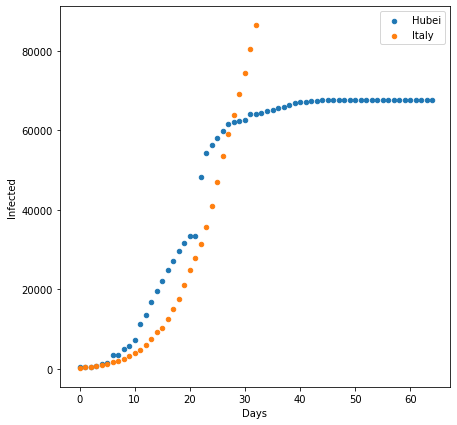

In [5]:
plt.figure(figsize=(7,7))
data_it = np.array(data_it)
plt.scatter(days_hub, data_hub, label = 'Hubei', s = 20)
plt.scatter(np.array(days_it[data_it > days_hub[0]]), data_it[data_it > days_hub[0]], label = 'Italy', s = 20)
plt.legend()
plt.xlabel('Days')
plt.ylabel('Infected')
plt.savefig('italy_hubei.png', dpi = 300, bbox_inches = 'tight')
plt.show()

This might suggest that Italy is still in growing in a sub-exponential fashion no plateau in sight, whereas Hubei around day 25 started to show a slowing-down in the number of new infections.

However, we should note that we should shift the temporal axis for each curve since we don't really know when each outbreak started. If we do this for Italy vs Hubei, and for other countries as well, we find a remarkable superposition at least in the initial exponential phase of the outbreak.

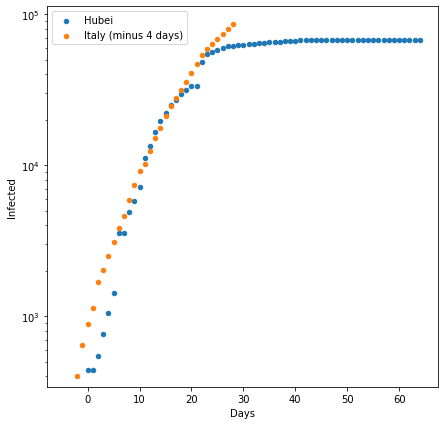

In [10]:
plt.figure(figsize=(7,7))
data_it = np.array(data_it)
plt.scatter(days_hub, data_hub, label = 'Hubei', s = 20)
plt.scatter(np.array(days_it[data_it > days_hub[0]])-4, data_it[data_it > days_hub[0]], label = 'Italy (minus 4 days)', s = 20)
plt.legend()
plt.xlabel('Days')
plt.ylabel('Infected')
plt.yscale('log')
plt.savefig('italy_hubei_tras.png', dpi = 300, bbox_inches = 'tight')
plt.show()

In a log scale, we see the sub-exponential increase of Italy's cases and a possible plateau should be reached in 10-20 days.

In [11]:
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'

clist = ['Italy', 'Spain', 'Germany', 'US', 'France', 'United Kingdom']
tlist = []

for country in clist:
    temp = []
    
    csv_file = request.urlopen(url).read().decode('utf8').split("\n")
    csv_reader = csv.DictReader(csv_file)
    for row in csv_reader:
        if row['Country/Region'] == country:
            temp.append(np.array(list(row.values())[4:]).astype('int'))
    tlist.append(np.sum(temp, axis = 0))

In [12]:
url= 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
clist = ['Italy', 'Spain', 'Germany', 'US', 'France', 'United Kingdom']
dlist = []

for country in clist:
    temp = []
    
    csv_file = request.urlopen(url).read().decode('utf8').split("\n")
    csv_reader = csv.DictReader(csv_file)
    for row in csv_reader:
        if row['Country/Region'] == country:
            temp.append(np.array(list(row.values())[4:]).astype('int'))
    dlist.append(np.sum(temp, axis = 0))
        

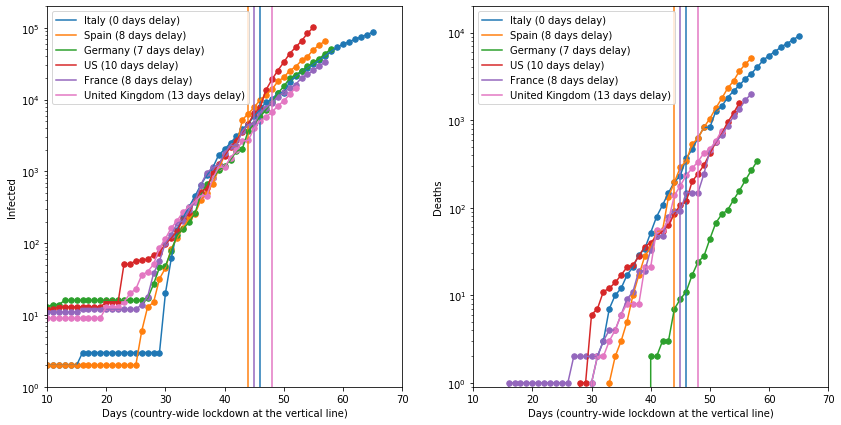

In [17]:
days = [np.arange(0,len(t), 1) for t in tlist]
days_t = [0, 8, 7, 10, 8, 13]
ld_list = [46, 52, None, None, 53, 61] # 46 is the index for 09/03, 52 for 15/03
                                         # 61 for 24/03

colorlist = plt.cm.tab10(np.linspace(0,len(days_t)/10,len(days_t)))    
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (14,7))

for x, y, l, dt, ld, c in zip(days, tlist, clist, days_t, ld_list, colorlist):
    ax[0].plot(x-dt,y, label = l + ' (' + str(dt) + ' days delay)', color = c)
    ax[0].scatter(x-dt,y, color = c, s= 30)
    if ld != None:
        ax[0].axvline(x=ld-dt, color = c)
        
ax[0].set_xlabel('Days (country-wide lockdown at the vertical line)')
ax[0].set_ylabel('Infected')
ax[0].set_yscale('log')
ax[0].set_xlim(10,70)
ax[0].set_ylim(1,200000)
ax[0].legend(loc = 2)

for x, y, l, dt, ld, c in zip(days, dlist, clist, days_t, ld_list, colorlist):
    ax[1].plot(x-dt,y, label = l + ' (' + str(dt) + ' days delay)', color = c)
    ax[1].scatter(x-dt,y, color = c, s = 30)
    if ld != None:
        ax[1].axvline(x=ld-dt, color = c)
    
ax[1].set_xlabel('Days (country-wide lockdown at the vertical line)')
ax[1].set_ylabel('Deaths')
ax[1].set_yscale('log')
ax[1].set_xlim(10,70)
ax[1].set_ylim(0.9,20000)
ax[1].legend(loc = 2)


plt.savefig('countries.png', dpi = 300, bbox_inches = 'tight')
plt.show()

All major countries are following the same curve after an initial transient, and only the US show a significant divergence from the others. This might be due to the way we count the infections, but at the same time it is a strong suggestion that all countries will find themselves in an identical situation in the long time limit. At the same time, the death rate is substantially different, suggesting that there might be some mismatchs in how the COVID-related deaths are counted with respect to the infections. However, note that all the curves increase in a similar way, so some of them might just be more delayed.

Now let's gather the data region-by-region in Italy.

In [56]:
def read_italy_region(region_name, *args):
    fields = [[] for _ in args]
    
    url = 'https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv'
    csv_file = request.urlopen(url).read().decode('utf8').split("\n")
    csv_reader = csv.DictReader(csv_file)
    
    line_count = 0
    for row in csv_reader:
        if row['denominazione_regione'] == region_name:
            for i, arg in enumerate(args):
                fields[i].append(int(row[arg]))
                    
    return fields

In [57]:
fields_names = ["totale_casi", "totale_attualmente_positivi", "deceduti", "dimessi_guariti", "tamponi",
                "totale_ospedalizzati", "terapia_intensiva"]
#fields_names_lab = ['Totale casi', 'Totale positivi', 'Deceduti', 'Guariti', 'Tamponi',
#                    'Ospedalizzati', 'Terapia intensiva']

fields_names_lab = ['Infected', 'Current cases', 'Deaths', 'Recovered', 'Tested', 'Hospitalized', 'Intensive care']

regions_list = []

url = 'https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv'
csv_file = request.urlopen(url).read().decode('utf8').split("\n")
csv_reader = csv.DictReader(csv_file)
line_count = 0
for row in csv_reader:
    regions_list.append(row['denominazione_regione'])
        
regions_list = list(set(regions_list))

In [58]:
def create_dict(regions_list, fields_names):
    rlist = []
    for region_name in regions_list:
        temp = zip(fields_names, read_italy_region(region_name, *fields_names))
        rlist.append(dict(temp))

    return dict(zip(regions_list, rlist))

In [59]:
r_timeseries = create_dict(regions_list, fields_names)

In [60]:
regions_dataframe = pd.DataFrame(r_timeseries).T

Let's look at what might seem as the top three regions in Italy, Lombardia, Emilia-Romagna and Veneto.

In [61]:
nlist = ['Veneto', 'Lombardia', 'Emilia Romagna']

def plot_comparison(regions_dataframe, nlist, fname, fname_lab):
    for name in nlist:
        data = regions_dataframe.at[name, fname]
        plt.scatter(np.arange(1,len(data)+1, 1), data, label = name, s = 20)
    plt.legend()
    plt.xlabel('Days')
    plt.ylabel(fname_lab)
    plt.show()

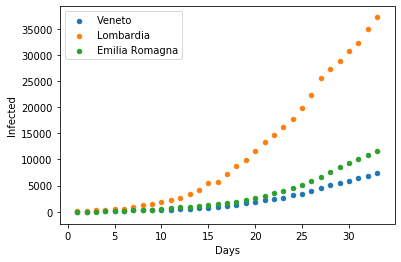

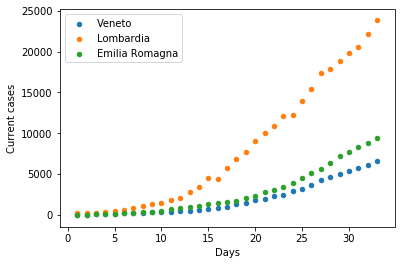

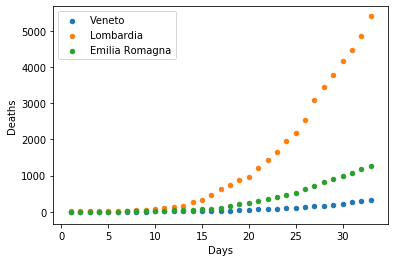

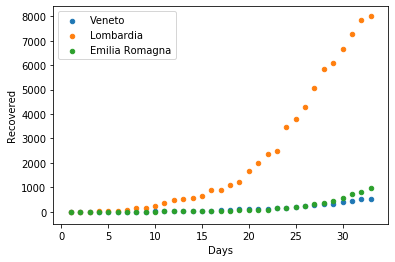

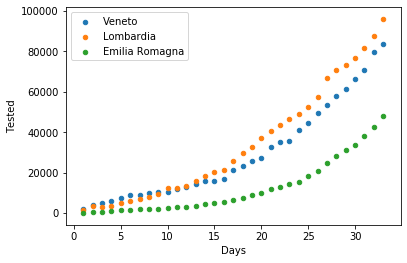

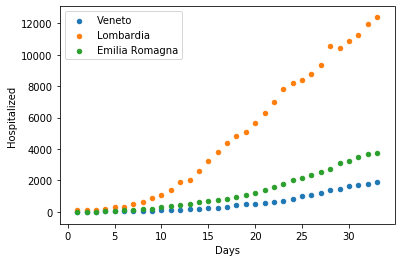

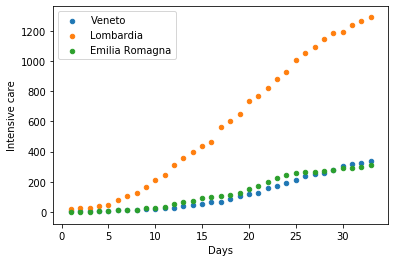

In [62]:
for fname, fname_lab in zip(fields_names, fields_names_lab):
    plot_comparison(regions_dataframe, nlist, fname, fname_lab)

This suggests that the number of tests performed plays a huge role in region-to-region comparison. Hence we should always normalize the number of infected to the number of tests performed. Let's build a dataframe merged together with geographical data to plot a map.

In [63]:
pos_tested = []
for name, data in r_timeseries.items():
    temp = np.array(data['totale_casi'])[-1]/np.array(data['tamponi'])[-1]
    pos_tested.append(temp*100)

pt_dict = dict(zip(['Regions','Percentage'],[regions_list, pos_tested]))
df = pd.DataFrame(pt_dict)

idx_trento = df.index[df['Regions'] == 'P.A. Trento']
idx_bolzano = df.index[df['Regions'] == 'P.A. Bolzano']

taa_p = (df.loc[idx_trento]['Percentage'].to_numpy() + df.loc[idx_bolzano]['Percentage'].to_numpy())/2
df.drop(idx_trento, inplace = True)
df.at[idx_bolzano, 'Regions'] = 'Trentino-Alto Adige'
df.at[idx_bolzano, 'Percentage'] = taa_p
df.at[df.index[df['Regions'] == 'Emilia Romagna'], 'Regions'] = 'Emilia-Romagna'

In [64]:
fp = '../italia/ConfiniRegionali/ConfiniRegionali.shp'
map_df = gpd.read_file(fp)

merged_ppos = map_df.set_index('DEN_REG').join(df.set_index('Regions'))

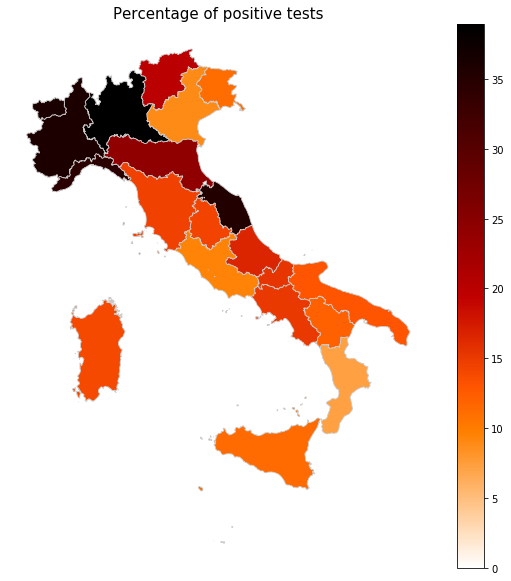

In [65]:
variable = 'Percentage'
fig, ax = plt.subplots(1,figsize=(10,10))

merged_ppos.plot(column = variable, cmap = 'gist_heat_r', linewidth = 0.8, ax = ax,
            edgecolor = '0.8', vmin = 0, legend = True)
ax.axis('off')
ax.set_title('Percentage of positive tests', fontdict={'fontsize':'15'})
plt.savefig('map.jpg', dpi = 300, bbox_inches = 'tight')

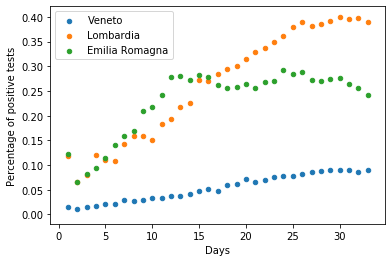

In [66]:
for name in nlist:
    data = np.array(regions_dataframe.at[name, 'totale_casi'])/np.array(regions_dataframe.at[name, 'tamponi'])
    plt.scatter(np.arange(1,len(data)+1, 1), data, label = name, s = 20)
plt.legend()
plt.xlabel('Days')
plt.ylabel('Percentage of positive tests')
plt.show()

We can also try different things. Let's look at the current situation and at the day-by-day increase.

In [77]:
def get_current_df(regions_dataframe):
    df = copy.deepcopy(regions_dataframe)
    for index, row in df.iterrows():
        for column in df:
            df.loc[index][column] = (row[column][-1])
            
    idx_trento = 'P.A. Trento'
    idx_bolzano = 'P.A. Bolzano'
        
    for fname in df:
        taa = df.loc[idx_trento][fname] + df.loc[idx_bolzano][fname]
        df.at[idx_bolzano, fname] = taa
      
    df.drop(idx_trento, inplace = True)
    df = df.rename(index={'P.A. Bolzano':'Trentino-Alto Adige'}) 
    df = df.rename(index={'Emilia Romagna':'Emilia-Romagna'}) 

    return df

def get_df_data(df, fname):
    tlist = df[fname].to_list()

    tdict = dict(zip(['Regions',fname],[df.index.to_list(), tlist]))
    new_df = pd.DataFrame(tdict)

    return new_df

current_df = get_current_df(regions_dataframe)
current_df.sort_values('terapia_intensiva', ascending = False)

,totale_casi,totale_attualmente_positivi,deceduti,dimessi_guariti,tamponi,totale_ospedalizzati,terapia_intensiva
Lombardia,37298,23895,5402,8001,95860,12429,1292
Piemonte,7092,6347,569,176,19705,3283,431
Veneto,7497,6648,313,536,83627,1874,338
Emilia-Romagna,11588,9361,1267,960,47798,3769,308
Toscana,3450,3170,177,103,23746,1327,274
Marche,3196,2850,336,10,9060,1141,162
Liguria,2696,2060,331,305,7804,1180,157
Lazio,2295,2013,118,164,24106,1118,126
Campania,1454,1292,98,64,9613,569,113
Trentino-Alto Adige,2394,1997,162,235,13443,701,111


In [68]:
it_current = pd.DataFrame(current_df.sum())
it_current.columns = ['Italia']
it_current.T

,totale_casi,totale_attualmente_positivi,deceduti,dimessi_guariti,tamponi,totale_ospedalizzati,terapia_intensiva
Italia,86498.0,66414.0,9134.0,10950.0,394079.0,29761.0,3732.0


In [69]:
def get_increment_df(regions_dataframe):
    df = copy.deepcopy(regions_dataframe)
    for index, row in df.iterrows():
        for column in df:
            df.loc[index][column] = np.diff(row[column])[-1]
            
    idx_trento = 'P.A. Trento'
    idx_bolzano = 'P.A. Bolzano'
        
    for fname in df:
        taa = df.loc[idx_trento][fname] + df.loc[idx_bolzano][fname]
        df.at[idx_bolzano, fname] = taa
      
    df.drop(idx_trento, inplace = True)
    df = df.rename(index={'P.A. Bolzano':'Trentino-Alto Adige'}) 
    df = df.rename(index={'Emilia Romagna':'Emilia-Romagna'}) 

    df.columns = ['inc_' + s for s in df.columns.to_list()]
    
    return df

increment_df = get_increment_df(regions_dataframe)
increment_df.sort_values('inc_totale_casi', ascending = False)

,inc_totale_casi,inc_totale_attualmente_positivi,inc_deceduti,inc_dimessi_guariti,inc_tamponi,inc_totale_ospedalizzati,inc_terapia_intensiva
Lombardia,2409,1706,541,162,8147,485,29
Emilia-Romagna,772,511,93,168,5403,114,7
Veneto,562,508,26,28,3868,101,12
Piemonte,558,397,120,41,1651,242,23
Toscana,224,197,19,8,2794,31,15
Lazio,199,178,12,9,1335,127,13
Trentino-Alto Adige,191,112,28,51,1099,69,2
Puglia,152,141,4,7,1042,56,6
Campania,144,123,15,6,1267,7,-1
Liguria,129,33,51,45,500,28,3


In [70]:
it_inc = pd.DataFrame(increment_df.sum())
it_inc.columns = ['Italia']
it_inc.T

,inc_totale_casi,inc_totale_attualmente_positivi,inc_deceduti,inc_dimessi_guariti,inc_tamponi,inc_totale_ospedalizzati,inc_terapia_intensiva
Italia,5959.0,4401.0,969.0,589.0,33019.0,1396.0,120.0


In [71]:
def plot_current(ax, fname, current_df, map_df, title):
    df = get_df_data(current_df, fname)
    
    merged = map_df.set_index('DEN_REG').join(df.set_index('Regions'))
    
    variable = fname
    merged.plot(column = variable, cmap = 'gist_heat_r', linewidth = 0.8, ax = ax,
                edgecolor = '0.8', vmin = 0, legend = True)
    ax.axis('off')
    ax.set_title(title, fontdict={'fontsize':'15'})

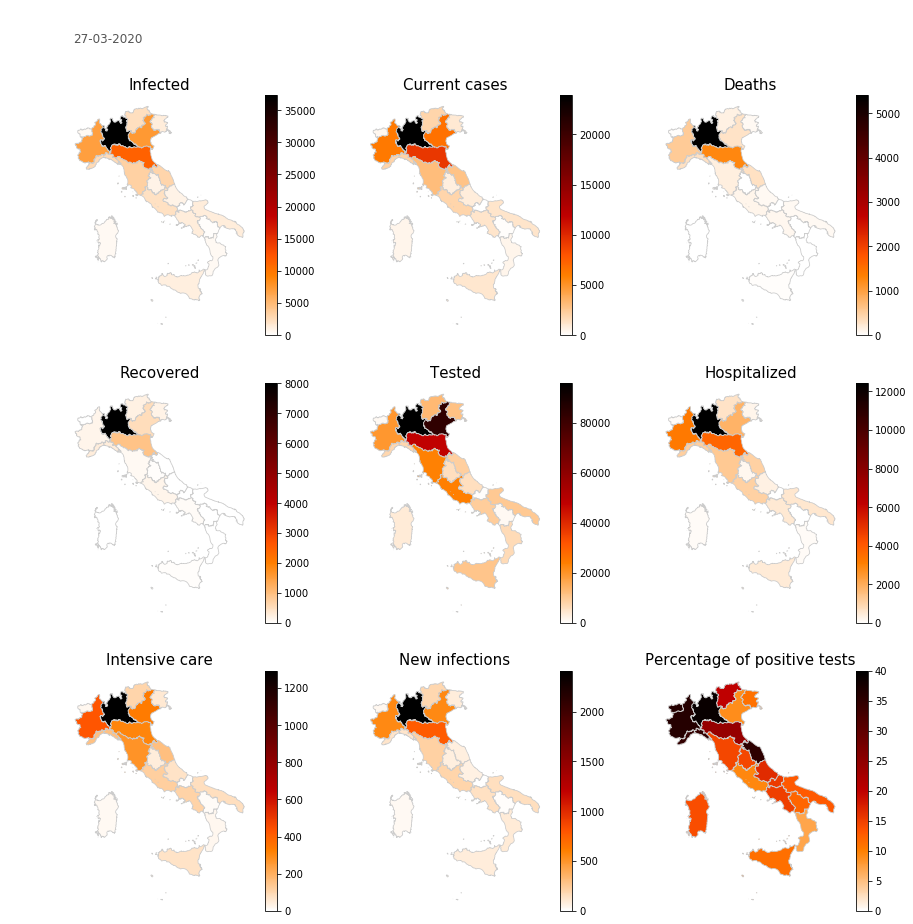

In [72]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize = (15,15))

#names_plot = ['Totale', 'Attualmente positivi', 'Deceduti', 'Dimessi',
#              'Tamponi', 'Ospedalizzati', 'Terapia intensiva']

names_plot = ['Infected', 'Current cases', 'Deaths', 'Recovered', 'Tested', 'Hospitalized', 'Intensive care']


for i, fname, title in zip(np.ndenumerate(np.zeros((3,3))), fields_names, names_plot):
    plot_current(ax[i[0]], fname, current_df, map_df, title)

plot_current(ax[2,1], 'inc_totale_casi', increment_df, map_df, 'New infections')

variable = 'Percentage'
vmin, vmax  = 0,40
merged_ppos.plot(column = variable, cmap = 'gist_heat_r', linewidth = 0.8, ax = ax[2,2],
            edgecolor = '0.8', vmin = vmin, vmax = vmax, legend = True)
ax[2,2].axis('off')
ax[2,2].set_title('Percentage of positive tests', fontdict={'fontsize':'15'})

plt.annotate(datetime.today().strftime('%d-%m-%Y'), xy=(0.08,0.95),  xycoords='figure fraction',
             horizontalalignment='left', verticalalignment='bottom',
             fontsize=12, color='#555555')
plt.savefig('tot.png', dpi = 300, bbox_inches = 'tight')

Another interesting metric is the number of hospitalizations with respect to the number of tests performed, since it is more likely that a sick person is tested and thus hospitalized. 

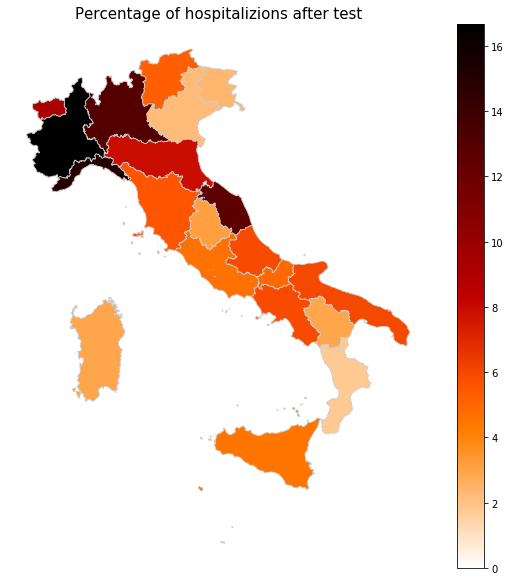

In [73]:
hosp_to_test = []
for rname in current_df.index.to_list():
    hosp_to_test.append(current_df.at[rname,'totale_ospedalizzati']*100/current_df.at[rname, 'tamponi'])
    
ht_dict = dict(zip(['Regions','percentuale_ospedalizzati'],[current_df.index.to_list(), hosp_to_test]))
ht_df = pd.DataFrame(ht_dict)
ht_df.set_index('Regions', inplace = True)

fig, ax = plt.subplots(1,figsize=(10,10))
plot_current(ax, 'percentuale_ospedalizzati', ht_df, map_df, 'Percentage of hospitalizions after test')

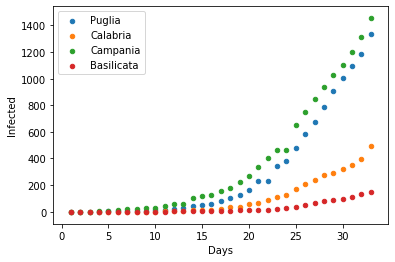

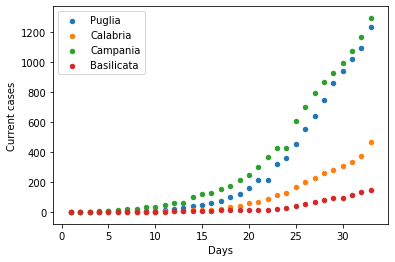

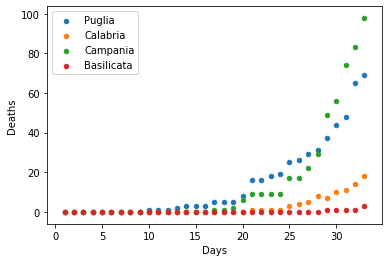

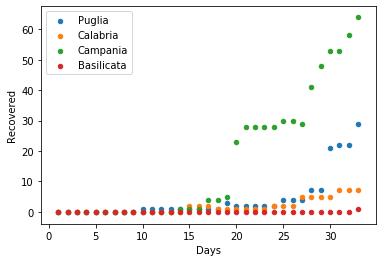

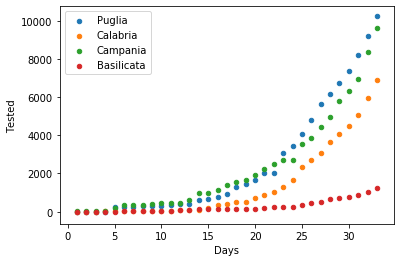

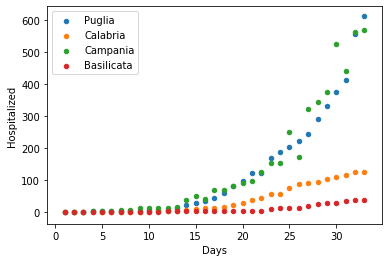

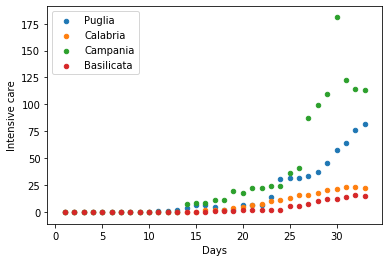

In [74]:
nlist = ['Puglia', 'Calabria', 'Campania', 'Basilicata']
for fname, fname_lab in zip(fields_names, fields_names_lab):
    plot_comparison(regions_dataframe, nlist, fname, fname_lab)